In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [3]:
df = pd.read_csv("../.data/processed/noise_data_cleaned.csv")
df.head()

,created_date,complaint_type,descriptor,borough,incident_zip,latitude,longitude,status,year,month,day,hour,day_of_week
0,2025-07-18 23:53:00,Noise,Noise: Construction Before/After Hours (NM1),MANHATTAN,10029.0,40.789950,-73.942927,Open,2025,7,18,23,Friday
1,2025-07-18 23:44:00,Noise,Noise: Construction Before/After Hours (NM1),MANHATTAN,10024.0,40.783600,-73.979428,Open,2025,7,18,23,Friday
2,2025-07-18 23:32:00,Noise,Noise: Construction Before/After Hours (NM1),STATEN ISLAND,10310.0,40.636057,-74.106825,Open,2025,7,18,23,Friday
3,2025-07-18 23:29:00,Noise,"Noise: Boat(Engine,Music,Etc) (NR10)",QUEENS,11357.0,40.791550,-73.795771,Open,2025,7,18,23,Friday
4,2025-07-18 23:26:00,Noise,"Noise: Boat(Engine,Music,Etc) (NR10)",QUEENS,11357.0,40.791550,-73.795771,Open,2025,7,18,23,Friday


### Handling Missing Values

In [4]:
missing_pct = df.isnull().mean().round(4).sort_values(ascending=False) * 100
print(df.isnull().sum())
missing_pct[missing_pct > 0]

created_date      0
complaint_type    0
descriptor        0
borough           0
incident_zip      0
latitude          0
longitude         0
status            0
year              0
month             0
day               0
hour              0
day_of_week       0
dtype: int64


Series([], dtype: float64)

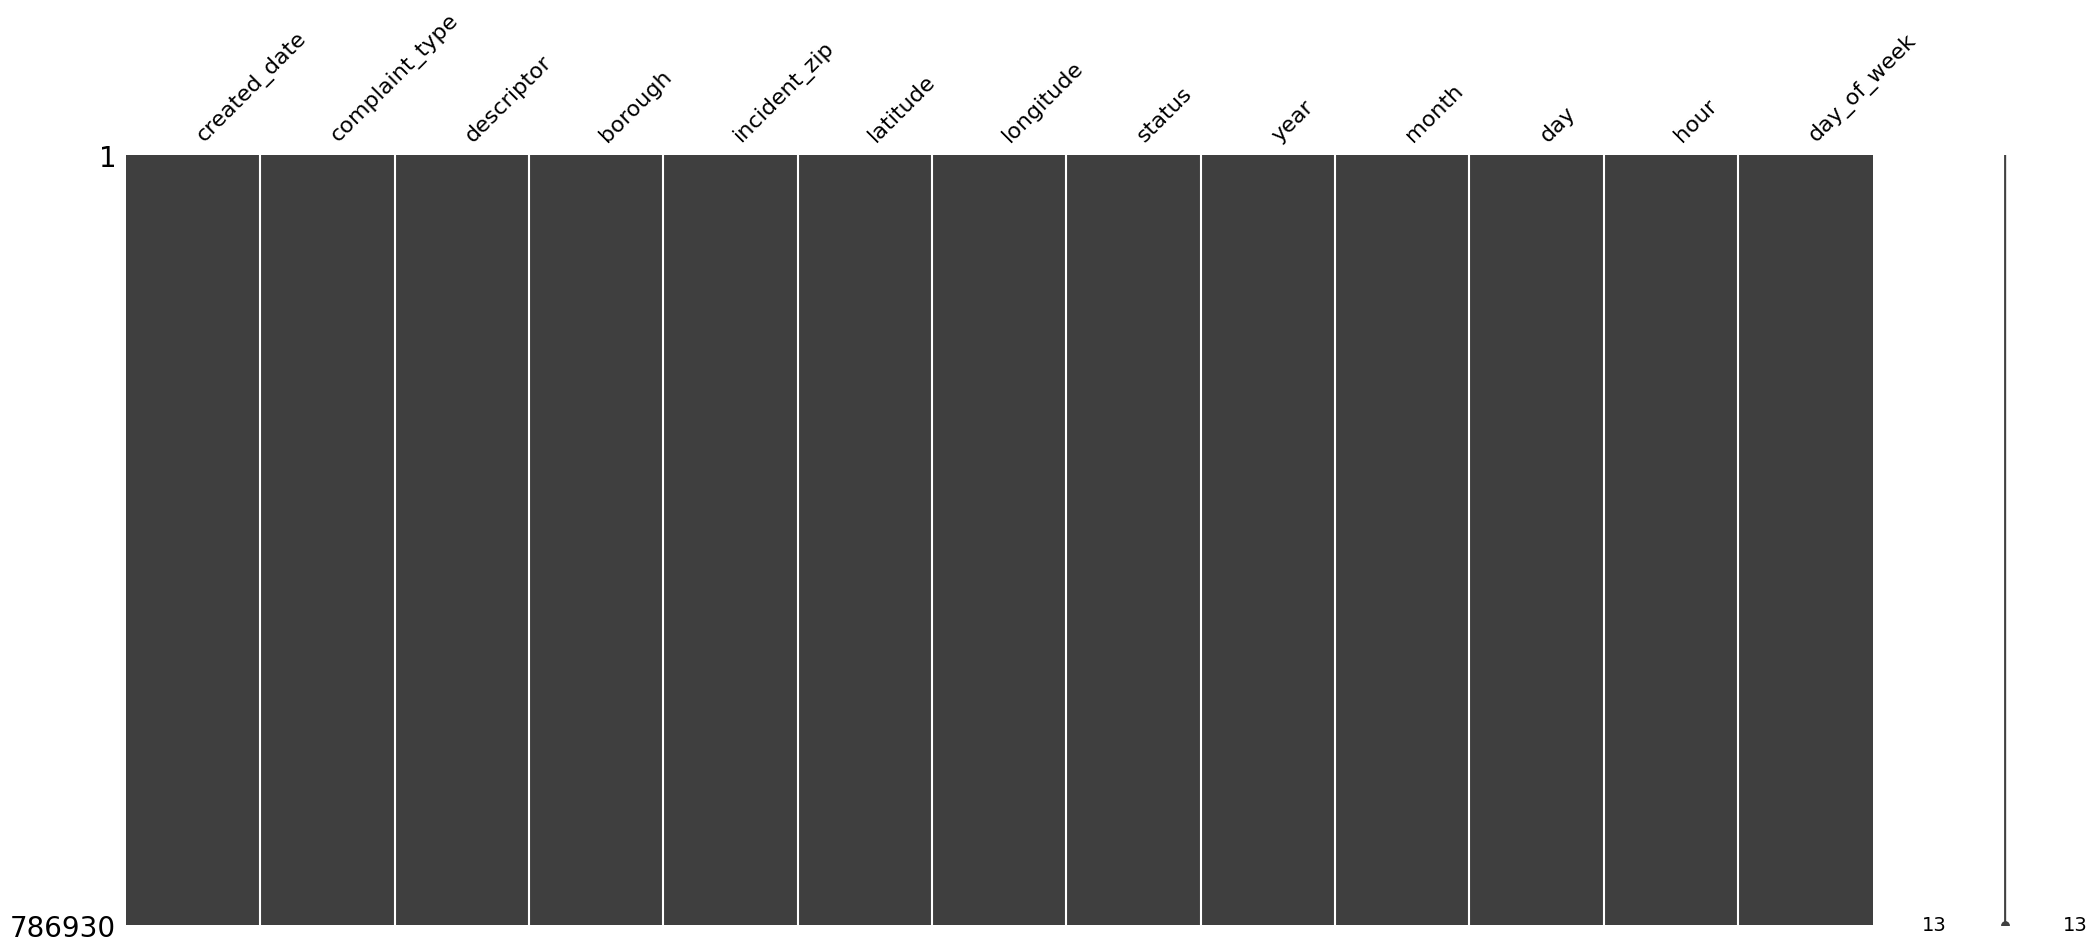

In [5]:
msno.matrix(df)
plt.show()

Lat & Long → missing together → you can’t map them.

Incident Zip → sometimes missing where coords are also missing.

These are spatial identifiers → if more than one is missing together, the row can’t be used for hotspot prediction.

In [6]:
df["borough"] = df["borough"].fillna("UNKNOWN")

df = df.dropna(subset="incident_zip")

In [7]:
missing_pct = df.isnull().mean().round(4).sort_values(ascending=False) * 100
print(df.isnull().sum())
missing_pct[missing_pct > 0]

created_date      0
complaint_type    0
descriptor        0
borough           0
incident_zip      0
latitude          0
longitude         0
status            0
year              0
month             0
day               0
hour              0
day_of_week       0
dtype: int64


Series([], dtype: float64)

In [8]:
zip_centroids = (
    df.dropna(subset=["latitude", "longitude"])
    .groupby("incident_zip")[["latitude", "longitude"]]
    .mean()
)

In [9]:
df["latitude"] = df.apply(
    lambda row: zip_centroids.loc[row["incident_zip"], "latitude"]
    if pd.isna(row["latitude"]) and row["incident_zip"] in zip_centroids.index
    else row["latitude"],
    axis=1
)

In [10]:
df["longitude"] = df.apply(
    lambda row: zip_centroids.loc[row["incident_zip"], "longitude"]
    if pd.isna(row["longitude"]) and row["incident_zip"] in zip_centroids.index
    else row["longitude"],
    axis=1
)

In [11]:
final_df = pd.read_csv("../.data/processed/noise_data_cleaned.csv")
final_df.head()

,created_date,complaint_type,descriptor,borough,incident_zip,latitude,longitude,status,year,month,day,hour,day_of_week
0,2025-07-18 23:53:00,Noise,Noise: Construction Before/After Hours (NM1),MANHATTAN,10029.0,40.789950,-73.942927,Open,2025,7,18,23,Friday
1,2025-07-18 23:44:00,Noise,Noise: Construction Before/After Hours (NM1),MANHATTAN,10024.0,40.783600,-73.979428,Open,2025,7,18,23,Friday
2,2025-07-18 23:32:00,Noise,Noise: Construction Before/After Hours (NM1),STATEN ISLAND,10310.0,40.636057,-74.106825,Open,2025,7,18,23,Friday
3,2025-07-18 23:29:00,Noise,"Noise: Boat(Engine,Music,Etc) (NR10)",QUEENS,11357.0,40.791550,-73.795771,Open,2025,7,18,23,Friday
4,2025-07-18 23:26:00,Noise,"Noise: Boat(Engine,Music,Etc) (NR10)",QUEENS,11357.0,40.791550,-73.795771,Open,2025,7,18,23,Friday


In [12]:
final_df.isnull().sum()

created_date      0
complaint_type    0
descriptor        0
borough           0
incident_zip      0
latitude          0
longitude         0
status            0
year              0
month             0
day               0
hour              0
day_of_week       0
dtype: int64

In [20]:
print(final_df["complaint_type"].value_counts())
print('\n---\n')
print(final_df["descriptor"].value_counts())

complaint_type
Noise                                     747363
Sewer                                      19174
Noise Survey                               16273
Collection Truck Noise                      2014
Sanitation Worker or Vehicle Complaint      1975
Plant                                        114
Internal Code                                 16
Water System                                   1
Name: count, dtype: int64

---

descriptor
Noise: Construction Before/After Hours (NM1)                                          303722
Noise, Barking Dog (NR5)                                                              107267
Noise: Construction Equipment (NC1)                                                   105801
Noise: Alarms (NR3)                                                                    57650
Noise: air condition/ventilation equipment (NV1)                                       57333
Noise: Jack Hammering (NC2)                                                          

In [36]:
# Unique descriptors
unique_descriptors = final_df["descriptor"].unique()
print(len(unique_descriptors))
print(unique_descriptors)

31
['Noise: Construction Before/After Hours (NM1)'
 'Noise: Boat(Engine,Music,Etc) (NR10)' 'Noise, Barking Dog (NR5)'
 'Noise: Jack Hammering (NC2)'
 'Noise: air condition/ventilation equipment (NV1)' 'Noise: Alarms (NR3)'
 'Noise: Construction Equipment (NC1)' 'Noise, Ice Cream Truck (NR4)'
 'Noise: Manufacturing Noise (NK1)' 'Noise:  lawn care equipment (NCL)'
 'Noise: Private Carting Noise (NQ1)' 'Noise, Other Animals (NR6)' 'Noise'
 'Noise: Other Noise Sources (Use Comments) (NZZ)'
 'Plants- Noise Related Problems (PN1)' 'Noise: Vehicle (NR2)'
 'Noise: Loud Music/Daytime (Mark Date And Time) (NN1)'
 'Noise: Other Noise Sources (Use Comments) - For Dep Internal Use Only (YNZZ)'
 'Manhole Cover Broken/Making Noise (SB)'
 'Noise: Construction Equipment - For Dep Internal Use Only (YNC1)'
 'Noise: Loud Music/Nighttime(Mark Date And Time) - For Dep Internal Use Only (YNP1)'
 'NOISE: AIR CONDITION/VENTILATION EQUIPMENT - FOR DEP INTERNAL USE ONLY (YNV1)'
 'Noise: Boat(Engine'
 'Noise: Lo

In [38]:
descriptor_counts = final_df["descriptor"].value_counts()
print(descriptor_counts.head(50))

descriptor
Noise: Construction Before/After Hours (NM1)                                          303722
Noise, Barking Dog (NR5)                                                              107267
Noise: Construction Equipment (NC1)                                                   105801
Noise: Alarms (NR3)                                                                    57650
Noise: air condition/ventilation equipment (NV1)                                       57333
Noise: Jack Hammering (NC2)                                                            45387
Noise, Ice Cream Truck (NR4)                                                           23436
Manhole Cover Broken/Making Noise (SB)                                                 19174
People Created Noise                                                                   16273
Noise: Private Carting Noise (NQ1)                                                     16179
Noise:  lawn care equipment (NCL)                          

In [48]:
updated_df = pd.read_csv("../.data/processed/final_noise_data.csv")
updated_df.head()

,created_date,descriptor,borough,incident_zip,latitude,longitude,status,year,month,day,hour,day_of_week,noise_category
0,2025-07-18 23:53:00,Noise: Construction Before/After Hours (NM1),MANHATTAN,10029.0,40.789950,-73.942927,Open,2025,7,18,23,Friday,Construction Noise
1,2025-07-18 23:44:00,Noise: Construction Before/After Hours (NM1),MANHATTAN,10024.0,40.783600,-73.979428,Open,2025,7,18,23,Friday,Construction Noise
2,2025-07-18 23:32:00,Noise: Construction Before/After Hours (NM1),STATEN ISLAND,10310.0,40.636057,-74.106825,Open,2025,7,18,23,Friday,Construction Noise
3,2025-07-18 23:29:00,"Noise: Boat(Engine,Music,Etc) (NR10)",QUEENS,11357.0,40.791550,-73.795771,Open,2025,7,18,23,Friday,Vehicle Noise
4,2025-07-18 23:26:00,"Noise: Boat(Engine,Music,Etc) (NR10)",QUEENS,11357.0,40.791550,-73.795771,Open,2025,7,18,23,Friday,Vehicle Noise


In [49]:
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786930 entries, 0 to 786929
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   created_date    786930 non-null  object 
 1   descriptor      786930 non-null  object 
 2   borough         786930 non-null  object 
 3   incident_zip    786930 non-null  float64
 4   latitude        786930 non-null  float64
 5   longitude       786930 non-null  float64
 6   status          786930 non-null  object 
 7   year            786930 non-null  int64  
 8   month           786930 non-null  int64  
 9   day             786930 non-null  int64  
 10  hour            786930 non-null  int64  
 11  day_of_week     786930 non-null  object 
 12  noise_category  786930 non-null  object 
dtypes: float64(3), int64(4), object(6)
memory usage: 78.0+ MB
